In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F # Import functions with an alias for clarity
import warnings

# Suppress specific warnings if needed (optional)
# warnings.filterwarnings("ignore", category=FutureWarning, module="pyspark.sql.pandas.conversion")

# Create or get a SparkSession
spark = SparkSession.builder \
    .appName("Project_4") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Enable Arrow-based columnar data transfers (improves Spark -> Pandas conversion performance)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Optional: Enable eager evaluation for better interactive display in notebooks
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

sqlContext = spark # Use spark variable directly, sqlContext is legacy

print(f"Spark Session Initialized. Spark version: {spark.version}")

Spark Session Initialized. Spark version: 3.5.3


## Cleaning and Preprocessing

In [13]:
df = spark.read.csv("../lab_data/2009.csv", header=True, inferSchema=True)

print("DataFrame Schema:")
df.printSchema()

print(f"\nNumber of records: {df.count()}")

DataFrame Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- W

In [14]:
# Rename columns for clarity and consistency
df = df \
    .withColumnRenamed("FL_DATE", "FlightDate") \
    .withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
    .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum") \
    .withColumnRenamed("ORIGIN", "Origin") \
    .withColumnRenamed("DEST", "Dest") \
    .withColumnRenamed("CRS_DEP_TIME", "CRSDepTime") \
    .withColumnRenamed("DEP_TIME", "DepTime") \
    .withColumnRenamed("DEP_DELAY", "DepDelay") \
    .withColumnRenamed("TAXI_OUT", "TaxiOut") \
    .withColumnRenamed("WHEELS_OFF", "WheelsOff") \
    .withColumnRenamed("WHEELS_ON", "WheelsOn") \
    .withColumnRenamed("TAXI_IN", "TaxiIn") \
    .withColumnRenamed("CRS_ARR_TIME", "CRSArrTime") \
    .withColumnRenamed("ARR_TIME", "ArrTime") \
    .withColumnRenamed("ARR_DELAY", "ArrDelay") \
    .withColumnRenamed("CANCELLED", "Cancelled") \
    .withColumnRenamed("CANCELLATION_CODE", "CancellationCode") \
    .withColumnRenamed("DIVERTED", "Diverted") \
    .withColumnRenamed("CRS_ELAPSED_TIME", "CRSElapsedTime") \
    .withColumnRenamed("ACTUAL_ELAPSED_TIME", "ActualElapsedTime") \
    .withColumnRenamed("AIR_TIME", "AirTime") \
    .withColumnRenamed("DISTANCE", "Distance") \
    .withColumnRenamed("CARRIER_DELAY", "CarrierDelay") \
    .withColumnRenamed("WEATHER_DELAY", "WeatherDelay") \
    .withColumnRenamed("NAS_DELAY", "NASDelay") \
    .withColumnRenamed("SECURITY_DELAY", "SecurityDelay") \
    .withColumnRenamed("LATE_AIRCRAFT_DELAY", "LateAircraftDelay")

# Unnamed column isn't useful, it gets dropped
df = df.drop("Unnamed: 27")

# Create DayOfWeek and Month features
df = df.withColumn("DayOfWeek", F.dayofweek("FlightDate"))
df = df.withColumn("Month", F.month("FlightDate"))

df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: double (nullable = true)
 |-- WheelsOn: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- WeatherDelay: double (nullable = true)
 

In [15]:
# Drop rows where key categorical or label fields are missing

number_of_rows = df.count()

df = df.dropna(subset=[
    "UniqueCarrier", "Origin", "Dest",
    "FlightDate", "Cancelled", "CRSDepTime", "CRSArrTime", "Distance"
])

print(f"Removed {number_of_rows - df.count()} rows")


# Fill missing delay values with 0 (assuming no delay)

missing_delay_count_before = df.filter(
    (F.col("DepDelay").isNull()) |
    (F.col("ArrDelay").isNull()) |
    (F.col("CarrierDelay").isNull()) |
    (F.col("WeatherDelay").isNull()) |
    (F.col("NASDelay").isNull()) |
    (F.col("SecurityDelay").isNull()) |
    (F.col("LateAircraftDelay").isNull())
).count()

df = df.fillna(0, subset=[
    "DepDelay", "ArrDelay", "CarrierDelay", "WeatherDelay", 
    "NASDelay", "SecurityDelay", "LateAircraftDelay"
])

missing_delay_count_after = df.filter(
    (F.col("DepDelay").isNull()) |
    (F.col("ArrDelay").isNull()) |
    (F.col("CarrierDelay").isNull()) |
    (F.col("WeatherDelay").isNull()) |
    (F.col("NASDelay").isNull()) |
    (F.col("SecurityDelay").isNull()) |
    (F.col("LateAircraftDelay").isNull())
).count()

affected_rows = missing_delay_count_before - missing_delay_count_after
print(f"Number of rows where delay values were filled with 0: {affected_rows}")

Removed 0 rows
Number of rows where delay values were filled with 0: 5258837


In [16]:
number_of_rows = df.count()

# Filter out diverted flights (remove DIVERTED = 1)
df = df.filter(F.col("Diverted") == 0)

print(f"Filtered out {number_of_rows - df.count()} rows")


Filtered out 15323 rows


In [17]:
# Write the cleaned and filtered DataFrame to a partitioned Parquet file
df.write.partitionBy("UniqueCarrier").mode("overwrite").parquet("../lab_data/clean_2009.parquet")

## Read in clean processed data

In [2]:
df = spark.read.parquet("../lab_data/clean_2009.parquet")
df.limit(5).toPandas()

,FlightDate,FlightNum,Origin,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,...,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfWeek,Month,UniqueCarrier
0,2009-03-04,12,DAL,ABQ,1025,1024.0,-1.0,6.0,1030.0,1102.0,...,92.0,580.0,0.0,0.0,0.0,0.0,0.0,4,3,WN
1,2009-03-18,782,ABQ,BWI,855,859.0,4.0,9.0,908.0,1422.0,...,194.0,1670.0,0.0,0.0,0.0,0.0,0.0,4,3,WN
2,2009-03-04,34,DAL,ABQ,1600,1600.0,0.0,8.0,1608.0,1640.0,...,92.0,580.0,0.0,0.0,0.0,0.0,0.0,4,3,WN
3,2009-03-18,237,ABQ,DAL,925,925.0,0.0,7.0,932.0,1153.0,...,81.0,580.0,0.0,0.0,0.0,0.0,0.0,4,3,WN
4,2009-03-04,50,DAL,ABQ,1955,1956.0,1.0,6.0,2002.0,2031.0,...,89.0,580.0,0.0,0.0,0.0,0.0,0.0,4,3,WN


## Exploratory Analysis

### Top 10 carriers by flight count

In [8]:
top_carriers = df.groupBy("UniqueCarrier") \
                         .count() \
                         .orderBy(F.desc("count")) \
                         .limit(10)

top_carriers.show()

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           WN|1127045|
|           AA| 548194|
|           OO| 544843|
|           MQ| 434577|
|           DL| 424982|
|           US| 411274|
|           UA| 375501|
|           XE| 308340|
|           EV| 297874|
|           NW| 291856|
+-------------+-------+



### Cancellation reasons by code

+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               B|36651|
|               A|35568|
|               C|14799|
|               D|   20|
+----------------+-----+



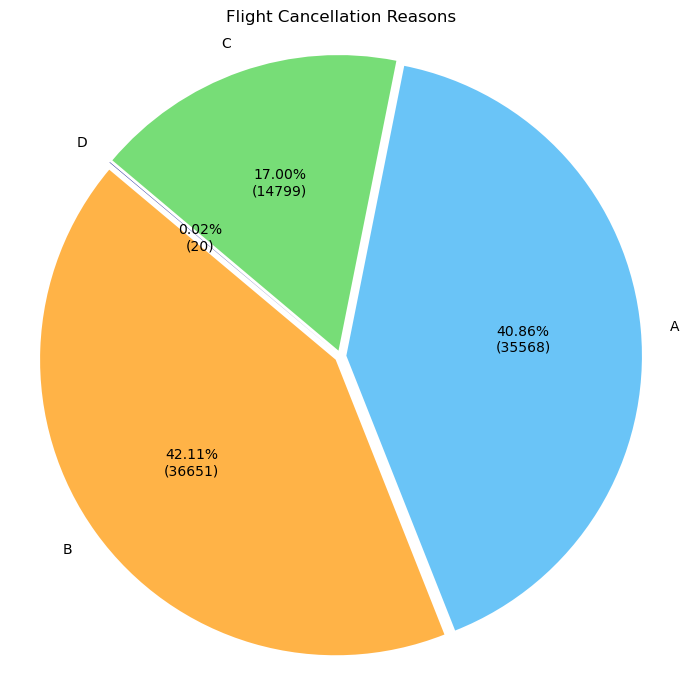

In [9]:
import matplotlib.pyplot as plt
import numpy as np

cancel_reasons = df \
                   .filter(F.col("Cancelled") == 1) \
                   .groupBy("CancellationCode") \
                   .count() \
                   .orderBy(F.desc("count"))

cancel_reasons.show()

cancel_reasons_pd = cancel_reasons.toPandas()

counts = cancel_reasons_pd['count']
labels = cancel_reasons_pd['CancellationCode']

# Custom autopct function to show small percentages and counts
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.2f}%\n({val})'

    return my_autopct

# Slightly separate each slice to improve displaying very small slices
explode = [0.02] * len(counts)

label_colors = {
    'A': '#6ac4f7',
    'B': '#ffb347',
    'C': '#77dd77',
    'D': '#01088c'
}

colors = [label_colors.get(label) for label in labels]

plt.figure(figsize=(7, 7))
plt.pie(counts,
        labels=labels,
        explode=explode,
        autopct=make_autopct(counts),
        startangle=140,
        colors=colors)

plt.title("Flight Cancellation Reasons")
plt.axis('equal')
plt.tight_layout()
plt.show()

### Class distribution and imbalance ratio

In [10]:
cancel_dist = df.groupBy("CANCELLED").count()
cancel_dist.show()

"""Imbalance ratio: the ratio of the sample size of the largest majority class and
that of the smallest minority class"""

counts = cancel_dist.collect()

largest_majority = counts[0]['count'] if counts[0]['CANCELLED'] == 0.0 else counts[1]['count']
smallest_minority = counts[1]['count'] if counts[0]['CANCELLED'] == 0.0 else counts[0]['count']
imbalance_ratio = largest_majority / smallest_minority

print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|6326977|
|      1.0|  87038|
+---------+-------+

Imbalance Ratio: 72.69


## Feature Engineering
### Feature selection

In [3]:
import pandas as pd
pd.set_option("display.max_columns", None)  # Show all columns
# trying to find "leaking" features. For example, if flight time or cancellation code is known, target value(was cancelled?) is also known
df.filter(F.col("Cancelled") == 1).summary("count", "mean", "min", "max").toPandas()


,summary,FlightNum,Origin,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfWeek,Month,UniqueCarrier
0,count,87038,87038,87038,87038,4171,87038,1251,1251,0,0,87038,0,87038,87038,87038,87038,87038,0,0,87038,87038,87038,87038,87038,87038,87038,87038,87038
1,mean,2915.115053195156,None,None,1354.7186286449596,1359.0803164708702,1.77334038006388,20.260591526778576,1404.6690647482014,None,None,1518.0080309749765,None,0.0,1.0,None,0.0,113.90246788758932,None,None,567.6134906592523,0.0,0.0,0.0,0.0,0.0,3.924274454835819,5.947310370183138,None
2,min,1,ABE,ABE,3,1.0,-31.0,1.0,12.0,None,None,1,None,0.0,1.0,A,0.0,1.0,None,None,11.0,0.0,0.0,0.0,0.0,0.0,1,1,9E
3,max,7816,YUM,YUM,2359,2400.0,1201.0,253.0,2359.0,None,None,2359,None,0.0,1.0,D,0.0,580.0,None,None,4962.0,0.0,0.0,0.0,0.0,0.0,7,12,YV


In [4]:
#compare against normal case
df.filter(F.col("Cancelled") == 0).summary("count", "mean", "min", "max").toPandas()


,summary,FlightNum,Origin,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfWeek,Month,UniqueCarrier
0,count,6326977,6326977,6326977,6326977,6326977,6326977,6326977,6326977,6326976,6326977,6326977,6326976,6326977,6326977,0,6326977,6326977,6326976,6326977,6326977,6326977,6326977,6326977,6326977,6326977,6326977,6326977,6326977
1,mean,2284.82700474492,None,None,1318.9852324419703,1325.9845872681376,7.547543953455181,16.027987141410502,1350.7602844138678,1478.3287557910762,6.889700721213306,1496.363955803854,1485.5144915991464,4.285590733141594,0.0,None,0.0,129.50537721252977,126.24342703370456,103.32572269505643,726.7472246224381,2.8612653404619617,0.509787691657485,3.042049307275813,0.011855424794495065,3.614478130709184,3.9333621728038524,6.410141367670532,None
2,min,1,ABE,ABE,1,1.0,-96.0,1.0,1.0,1.0,0.0,1,1.0,-107.0,0.0,None,0.0,4.0,14.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1,1,9E
3,max,7829,YUM,YUM,2359,2400.0,2445.0,458.0,2400.0,2400.0,197.0,2400,2400.0,2449.0,0.0,None,0.0,660.0,799.0,699.0,4962.0,2439.0,1114.0,1305.0,345.0,1391.0,7,12,YV


In [5]:
features_to_drop = [
    "DepTime", "TaxiOut", "WheelsOff", "WheelsOn","TaxiIn", "ArrTime",
    "ArrDelay", "CancellationCode", "Diverted", "ActualElapsedTime",
    "AirTime", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
]
data_to_predict = df.drop(*features_to_drop)
data_to_predict = data_to_predict.drop("FlightNum") #unsure if random number of consist meaningful info


### Feature Processing

In [32]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

data_to_predict = data_to_predict.withColumn("DepHour", (F.col("CRSDepTime") / 100).cast("int"))
data_to_predict = data_to_predict.withColumn("ArrHour", (F.col("CRSArrTime") / 100).cast("int"))
#making hours 0 and 23 close (cyclical) 
data_to_predict = data_to_predict.withColumn("DepHour_sin", F.sin(2 * 3.1416 * F.col("DepHour") / 24))
data_to_predict = data_to_predict.withColumn("DepHour_cos", F.cos(2 * 3.1416 * F.col("DepHour") / 24))
data_to_predict = data_to_predict.withColumn("ArrHour_sin", F.sin(2 * 3.1416 * F.col("ArrHour") / 24))
data_to_predict = data_to_predict.withColumn("ArrHour_cos", F.cos(2 * 3.1416 * F.col("ArrHour") / 24))

categorical_cols = ["Origin", "Dest", "UniqueCarrier", "DayOfWeek", "Month"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_vec", handleInvalid="keep") for col in categorical_cols]

assembler_inputs = [
    "DepDelay", "CRSElapsedTime", "Distance",
    "DepHour_sin", "DepHour_cos", "ArrHour_sin", "ArrHour_cos"
] + [col+"_vec" for col in categorical_cols]


assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid="keep")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
model = pipeline.fit(data_to_predict)
df_prepared = model.transform(data_to_predict)
columns_to_drop = categorical_cols + ["CRSDepTime", "CRSArrTime", "DepHour", "ArrHour"]
df_prepared = df_prepared.drop(*columns_to_drop) #already converted

In [7]:
df_prepared = df_prepared.select("features", "Cancelled")

# spark split does not have target stratification
cancelled = df_prepared.filter(F.col("Cancelled") == 1.0)
not_cancelled = df_prepared.filter(F.col("Cancelled") == 0.0)

cancelled_train, cancelled_test = cancelled.randomSplit([0.7, 0.3], seed=42)
not_cancelled_train, not_cancelled_test = not_cancelled.randomSplit([0.7, 0.3], seed=42)

train_df = cancelled_train.union(not_cancelled_train)
test_df = cancelled_test.union(not_cancelled_test)
train_df.cache()
test_df.cache()
train_df.limit(5).toPandas()

,features,Cancelled
0,"(-6.0, 140.0, 732.0, 0.7071028851534585, -0.70...",1.0
1,"(-6.0, 105.0, 595.0, 0.9999999999932537, -3.67...",1.0
2,"(5.0, 130.0, 867.0, 0.86602295497065, -0.50000...",1.0
3,"(162.0, 140.0, 867.0, -0.999999999939284, 1.10...",1.0
4,"(85.0, 135.0, 733.0, -0.5000074225224785, -0.8...",1.0


## Modeling

In [23]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [24]:
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", metricName="areaUnderROC")
accuracy_eval = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy"
)

### LogisticRegression

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="Cancelled")
lr_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0]).build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator, numFolds=3)
lr_model = lr_cv.fit(train_df)

predictions = lr_model.transform(test_df)

accuracy = accuracy_eval.evaluate(predictions)
auc = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

predictions.unpersist() # Hopefully frees up a bit of memory

Accuracy: 0.9865
AUC: 0.7604


DataFrame[features: vector, Cancelled: double, rawPrediction: vector, probability: vector, prediction: double]

### DecisionTreeClassifier

In [10]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Cancelled")
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [2, 4, 6]).build()
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, evaluator=evaluator, numFolds=3)
dt_model = dt_cv.fit(train_df)

predictions = dt_model.transform(test_df)

accuracy = accuracy_eval.evaluate(predictions)
auc = evaluator.evaluate(predictions)

print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(f"Decision Tree AUC: {auc:.4f}")

predictions.unpersist()

Decision Tree Accuracy: 0.9866
Decision Tree AUC: 0.9142


DataFrame[features: vector, Cancelled: double, rawPrediction: vector, probability: vector, prediction: double]

### RandomForestClassifier

In [11]:
rf = RandomForestClassifier(featuresCol="features", labelCol="Cancelled")
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 50]).build()
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator, numFolds=3)
rf_model = rf_cv.fit(train_df)

predictions = rf_model.transform(test_df)

accuracy = accuracy_eval.evaluate(predictions)
auc = evaluator.evaluate(predictions)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest AUC: {auc:.4f}")

predictions.unpersist()

Random Forest Accuracy: 0.9865
Random Forest AUC: 0.8381


DataFrame[features: vector, Cancelled: double, rawPrediction: vector, probability: vector, prediction: double]

### GBTClassifier

In [10]:
gbt = GBTClassifier(featuresCol="features", labelCol="Cancelled")

# Search over only 2 hyperparameters since this takes a very long time to run
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [5, 10]).build()
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=evaluator, numFolds=3)
gbt_model = gbt_cv.fit(train_df)

predictions = gbt_model.transform(test_df)

accuracy = accuracy_eval.evaluate(predictions)
auc = evaluator.evaluate(predictions)

print(f"GBT Accuracy: {accuracy:.4f}")
print(f"GBT AUC: {auc:.4f}")

predictions.unpersist()

GBT Accuracy: 0.9865
GBT AUC: 0.9674


DataFrame[features: vector, Cancelled: double, rawPrediction: vector, probability: vector, prediction: double]

## Determining the best model

Comparing the resulting accuracy and AUC scores clearly shows that the best model for this task is the <b>GBTClassifier</b>.

In [14]:
best_model = gbt_model.bestModel

# Save the best model to disk
best_model_path = "../lab_data/best_model"
best_model.write().overwrite().save(best_model_path)

In [10]:
# Load the model back
from pyspark.ml.classification import GBTClassificationModel

best_model = GBTClassificationModel.load(best_model_path)

## Explainability

         feature  importance
        DepDelay    0.577819
1hot-feature-633    0.045364
1hot-feature-625    0.035725
1hot-feature-628    0.031063
1hot-feature-632    0.028421
1hot-feature-607    0.025888
        Distance    0.025275
1hot-feature-317    0.024950
 1hot-feature-26    0.024445
1hot-feature-304    0.024180
1hot-feature-322    0.022336
1hot-feature-600    0.018567
1hot-feature-614    0.017322
     DepHour_sin    0.016815
1hot-feature-618    0.015340
1hot-feature-602    0.011984
1hot-feature-634    0.011144
1hot-feature-599    0.010582
1hot-feature-624    0.009386
 1hot-feature-21    0.009379


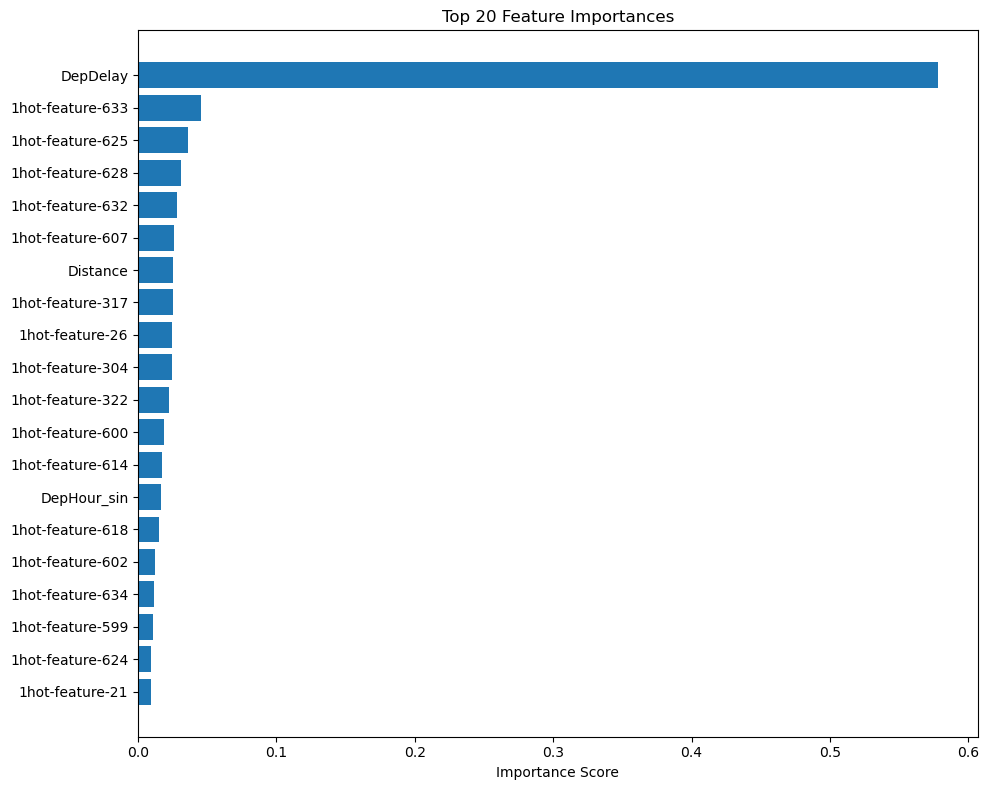

In [6]:
# Get feature importances
importances = best_model.featureImportances.toArray()

# Main assembler inputs from pipeline 
numeric_feature_names = [
    "DepDelay", 
    "CRSElapsedTime", 
    "Distance",
    "DepHour_sin", 
    "DepHour_cos", 
    "ArrHour_sin", 
    "ArrHour_cos"
]

# Generate rest of the 1Hot features
feature_names = []
for i in range(len(importances)):
    if i < len(numeric_feature_names):
        feature_names.append(numeric_feature_names[i])
    else:
        feature_names.append(f"1hot-feature-{i}")

# Sort by importance + plot top 20
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

top_20 = importance_df.head(20)
print(top_20[['feature', 'importance']].to_string(index=False))

plt.figure(figsize=(10, 8))
plt.barh(top_20['feature'][::-1], top_20['importance'][::-1])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [29]:
# Translate generic 1hot feature names

# ID one-hot encoding features from stored model
categorical_cols = ["Origin", "Dest", "UniqueCarrier", "DayOfWeek", "Month"]

category_mappings = {}

for col in categorical_cols:
    categories = (data_to_predict
                 .select(col)
                 .distinct()
                 .orderBy(col)
                 .rdd.flatMap(lambda x: x)
                 .collect())
    category_mappings[col] = categories

# Create complete feature name mapping
feature_names = [
    "DepDelay", 
    "CRSElapsedTime", 
    "Distance",
    "DepHour_sin", 
    "DepHour_cos",
    "ArrHour_sin",
    "ArrHour_cos"
]

# Add categorical feature names with actual values (if applicable)
for col in categorical_cols:
    if col in category_mappings:
        for i, category in enumerate(category_mappings[col]):
            feature_names.append(f"{col}_{category}")
    else:
        # Fallback if we couldn't get categories
        num_categories = len(data_to_predict.select(col).distinct().collect())
        feature_names.extend([f"{col}_cat{i}" for i in range(num_categories)])

# Map all 1Hot indices from chart above
top_ind = [633, 625, 628, 632, 607, 317, 26, 304, 322, 600, 614, 618, 602, 634, 599, 624, 21]

print("\nTop Feature Mappings:")
for idx in top_ind:
    if idx < len(feature_names):
        print(f"Index {idx}: {feature_names[idx]}")
    else:
        print(f"Index {idx}: Out of bounds (max feature vector length is {len(feature_names)})")


Top Feature Mappings:
Index 633: Month_9
Index 625: Month_1
Index 628: Month_4
Index 632: Month_8
Index 607: UniqueCarrier_FL
Index 317: Dest_ALO
Index 26: Origin_ATW
Index 304: Dest_ABI
Index 322: Dest_ATW
Index 600: UniqueCarrier_AA
Index 614: UniqueCarrier_US
Index 618: DayOfWeek_1
Index 602: UniqueCarrier_B6
Index 634: Month_11
Index 599: UniqueCarrier_9E
Index 624: DayOfWeek_7
Index 21: Origin_ALO


### Top 10 Features by Importance

| Rank | Feature Index | Decoded Feature            | Importance Score | Interpretation |
|------|---------------|----------------------------|------------------|----------------|
| 1    | -             | **DepDelay**               | 0.5778           | Departure delay |
| 2    | 633           | Month_9 (September)        | 0.0454           | Peak hurricane season |
| 3    | 625           | Month_1 (January)          | 0.0357           | Winter storms |
| 4    | 628           | Month_4 (April)            | 0.0311           | Spring break travel disruptions |
| 5    | 632           | Month_8 (August)           | 0.0284           | Summer travel peaks |
| 6    | 607           | UniqueCarrier_FL (AirTran) | 0.0259           | Out-of-business carrier |
| 7    | -             | **Distance**               | 0.0253           | Longer flight risk |
| 8    | 317           | Dest_ALO (Waterloo, IA)    | 0.0249           | Small Airport, Unpredictable Midwest weather |
| 9    | 26            | Origin_ATW (Appleton, WI)  | 0.0244           | Small Airport, Unpredicatable Midwest Weather |
| 10   | 304           | Dest_ABI (Abilene, TX)     | 0.0242           | Small Airport, Extreme Texas Weather |

## Building the full pipeline

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import functions as F

# Encapsulates the preprocessing steps into a reusable transformer, so we can use it in a pipeline
class Preprocessor(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self):
        super(Preprocessor, self).__init__()

    def _transform(self, df):
        df = df \
            .withColumnRenamed("FL_DATE", "FlightDate") \
            .withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
            .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum") \
            .withColumnRenamed("ORIGIN", "Origin") \
            .withColumnRenamed("DEST", "Dest") \
            .withColumnRenamed("CRS_DEP_TIME", "CRSDepTime") \
            .withColumnRenamed("DEP_TIME", "DepTime") \
            .withColumnRenamed("DEP_DELAY", "DepDelay") \
            .withColumnRenamed("TAXI_OUT", "TaxiOut") \
            .withColumnRenamed("WHEELS_OFF", "WheelsOff") \
            .withColumnRenamed("WHEELS_ON", "WheelsOn") \
            .withColumnRenamed("TAXI_IN", "TaxiIn") \
            .withColumnRenamed("CRS_ARR_TIME", "CRSArrTime") \
            .withColumnRenamed("ARR_TIME", "ArrTime") \
            .withColumnRenamed("ARR_DELAY", "ArrDelay") \
            .withColumnRenamed("CANCELLED", "Cancelled") \
            .withColumnRenamed("CANCELLATION_CODE", "CancellationCode") \
            .withColumnRenamed("DIVERTED", "Diverted") \
            .withColumnRenamed("CRS_ELAPSED_TIME", "CRSElapsedTime") \
            .withColumnRenamed("ACTUAL_ELAPSED_TIME", "ActualElapsedTime") \
            .withColumnRenamed("AIR_TIME", "AirTime") \
            .withColumnRenamed("DISTANCE", "Distance") \
            .withColumnRenamed("CARRIER_DELAY", "CarrierDelay") \
            .withColumnRenamed("WEATHER_DELAY", "WeatherDelay") \
            .withColumnRenamed("NAS_DELAY", "NASDelay") \
            .withColumnRenamed("SECURITY_DELAY", "SecurityDelay") \
            .withColumnRenamed("LATE_AIRCRAFT_DELAY", "LateAircraftDelay")

        if "Unnamed: 27" in df.columns:
            df = df.drop("Unnamed: 27")

        if "FlightDate" in df.columns:
            df = df.withColumn("DayOfWeek", F.dayofweek(F.col("FlightDate")))
            df = df.withColumn("Month", F.month(F.col("FlightDate")))

        subset_dropna = [
            "UniqueCarrier", "Origin", "Dest",
            "FlightDate", "Cancelled", "CRSDepTime", "CRSArrTime", "Distance"
        ]

        actual_subset_dropna = [c for c in subset_dropna if c in df.columns]
        if actual_subset_dropna:
            df = df.dropna(subset=actual_subset_dropna)

        delay_cols_to_fill = [
            "DepDelay", "ArrDelay", "CarrierDelay", "WeatherDelay",
            "NASDelay", "SecurityDelay", "LateAircraftDelay"
        ]
        actual_delay_cols_to_fill = [c for c in delay_cols_to_fill if c in df.columns]
        if actual_delay_cols_to_fill:
            df = df.fillna(0, subset=actual_delay_cols_to_fill)
        
        if "Diverted" in df.columns:
            df = df.filter(F.col("Diverted") == 0)

        features_to_drop_leaking = [
            "DepTime", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn", "ArrTime",
            "ArrDelay", "CancellationCode", "Diverted", "ActualElapsedTime",
            "AirTime", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
        ]
        actual_features_to_drop_leaking = [c for c in features_to_drop_leaking if c in df.columns]
        if actual_features_to_drop_leaking:
            df = df.drop(*actual_features_to_drop_leaking)

        if "FlightNum" in df.columns:
            df = df.drop("FlightNum")

        df = df.withColumn("DepHour", (F.col("CRSDepTime") / 100).cast("int"))
        df = df.withColumn("ArrHour", (F.col("CRSArrTime") / 100).cast("int"))
        df = df.withColumn("DepHour_sin", F.sin(2 * 3.1416 * F.col("DepHour") / 24))
        df = df.withColumn("DepHour_cos", F.cos(2 * 3.1416 * F.col("DepHour") / 24))
        df = df.withColumn("ArrHour_sin", F.sin(2 * 3.1416 * F.col("ArrHour") / 24))
        df = df.withColumn("ArrHour_cos", F.cos(2 * 3.1416 * F.col("ArrHour") / 24))
            
        return df

In [19]:
df_2010 = spark.read.csv("../lab_data/2010.csv", header=True, inferSchema=True)

In [33]:
full_pipeline = Pipeline(stages=[
    Preprocessor(),
    model, # Already fitted pipeline (it's also a transformer so we can just use it like this)
    best_model # Fitted GBT model
])

full_pipeline_model = full_pipeline.fit(df_2010)

In [38]:
predictions = full_pipeline_model.transform(df_2010)

accuracy = accuracy_eval.evaluate(predictions)
auc = evaluator.evaluate(predictions)

print(f"2010 Data Accuracy: {accuracy:.4f}")
print(f"2010 Data AUC: {auc:.4f}")

2010 Data Accuracy: 0.9824
2010 Data AUC: 0.9555


In [39]:
# Save the full pipeline model to disk
full_pipeline_model_path = "../lab_data/full_pipeline_model"
full_pipeline_model.write().overwrite().save(full_pipeline_model_path)